In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Generate Data
***

# $y_{true}=mx+b$
# $y=y_{true} + N(0,\sigma)$
***

In [2]:
true_slope = 5
true_intercept = 10
true_sigma = 1

num_points = 10

x_vals = np.linspace(0, 1, num_points)
true_y_vals = true_slope * x_vals + true_intercept

# some samples drawn from line / training data
y_vals = true_y_vals + np.random.normal(scale=true_sigma, size=num_points)

true_params = {"slope": true_slope, "intercept": true_intercept, "sigma": true_sigma}

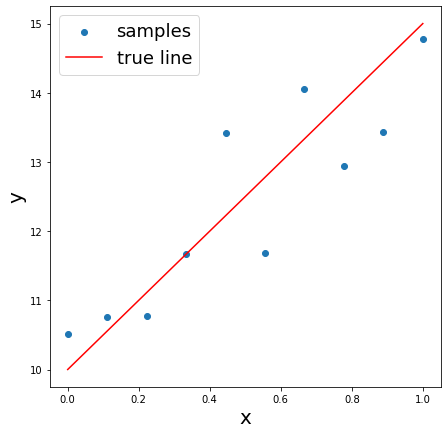

In [12]:
plt.figure(figsize=(7, 7))
p1 = plt.scatter(x_vals, y_vals)
(p2,) = plt.plot(x_vals, true_y_vals, color="r")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)
plt.legend((p1, p2), ("samples", "true line"), fontsize=18)

# Fit a Usual Linear Model

In [4]:
clf = LinearRegression()
clf.fit(x_vals.reshape(-1, 1), y_vals)
preds = clf.predict(x_vals.reshape(-1, 1))
resids = preds - y_vals

print("True Model:")
print("y_true = %s*x + %s" % (true_slope, true_intercept))
print("True sigma: %s\n" % true_params["sigma"])

print("Estimated Model:")
print("y_hat = %s*x + %s" % (clf.coef_[0], clf.intercept_))
print("Sd Residuals: %s" % (resids.std()))

mle_estimates = {
    "slope": clf.coef_[0],
    "intercept": clf.intercept_,
    "sigma": resids.std(),
}

True Model:
y_true = 5*x + 10
True sigma: 1

Estimated Model:
y_hat = 4.002347479730105*x + 10.401340052488946
Sd Residuals: 0.6665292262246947


# Bayesian Analysis with PyMC3
***

# Priors:
## $m \sim N(0,20)$
## $b \sim N(0,20)$
## $\sigma \sim Exp(1)$
***

# Likelihood:
## $y|m,b,\sigma \sim N(mx+b, \sigma)$
***

# Posterior
## $m,b,\sigma | y \sim ?$
## $P(m,b,\sigma|y) \propto P(y|m,b,\sigma) \times P(m) \times P(b) \times P(\sigma)$
***

In [13]:
with pm.Model() as model:
    # priors
    sigma = pm.Exponential("sigma", lam=1.0)
    intercept = pm.Normal("intercept", mu=0, sigma=20)
    slope = pm.Normal("slope", mu=0, sigma=20)

    # Likelihood
    likelihood = pm.Normal(
        "y", mu=slope * x_vals + intercept, sigma=sigma, observed=y_vals
    )

    # posterior
    trace = pm.sample(1000, cores=4)

/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [slope, intercept, sigma]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


<Figure size 504x504 with 0 Axes>

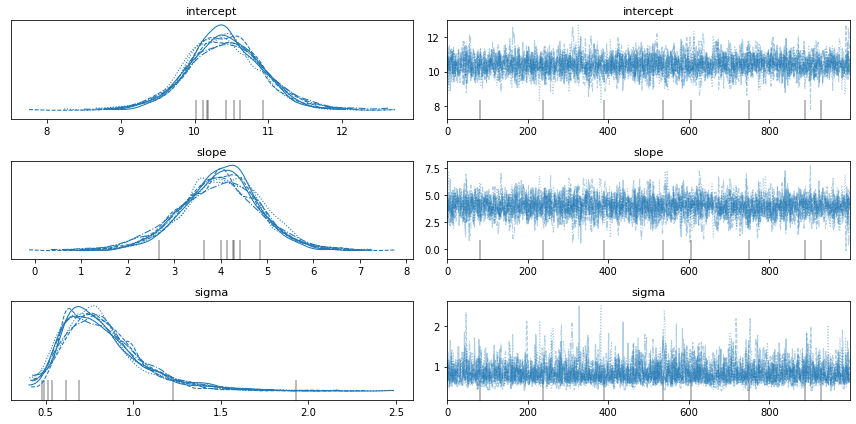

In [14]:
plt.figure(figsize=(7, 7))
pm.plot_trace(trace)
plt.tight_layout()

<Figure size 720x288 with 0 Axes>

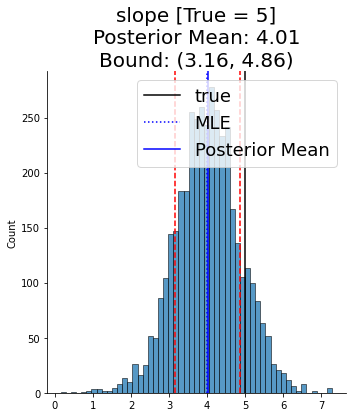

<Figure size 720x288 with 0 Axes>

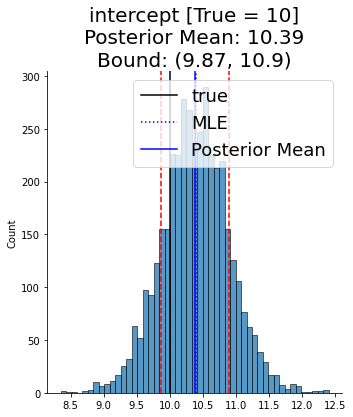

<Figure size 720x288 with 0 Axes>

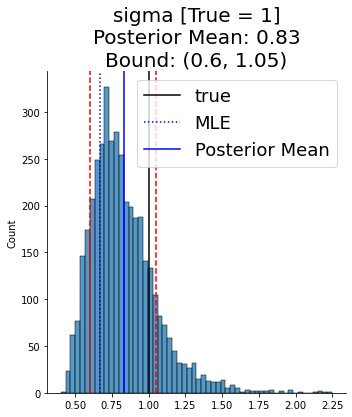

In [11]:
for var in ["slope", "intercept", "sigma"]:
    plt.figure(figsize=(10, 4))
    vals = trace.get_values(var)
    mean, lower, upper = (
        round(vals.mean(), 2),
        round(vals.mean() - vals.std(), 2),
        round(vals.mean() + vals.std(), 2),
    )
    sns.displot(vals)
    posterior_est = plt.axvline(mean, color="b")
    mle_est = plt.axvline(mle_estimates[var], color="b", linestyle="dotted")
    plt.axvline(lower, color="r", linestyle="--")
    plt.axvline(upper, color="r", linestyle="--")
    plt.title(
        "%s [True = %s]\nPosterior Mean: %s\nBound: (%s, %s)"
        % (var, true_params[var], mean, lower, upper),
        fontsize=20,
    )
    true_val = plt.axvline(true_params[var], color="k")

    plt.legend(
        (true_val, mle_est, posterior_est),
        ("true", "MLE", "Posterior Mean"),
        fontsize=18,
    )

    plt.show()